<a href="https://colab.research.google.com/github/mattfarrow1/7331-machine-learning-1/blob/main/Labs/Lab1_Group4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab One: Visualization and Data Preprocessing

Matt Farrow, Amber Clark, Blake Freeman, Megan Ball

## **2015 Flight Delays and Cancellations**
Data Source: [Kaggle](https://www.kaggle.com/usdot/flight-delays?select=flights.csv)

## Business Understanding

`Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). Describe how you would define and measure the outcomes from the dataset. That is, why is this data important and how do you know if you have mined useful knowledge from the dataset? How would you measure the effectiveness of a good prediction algorithm? Be specific.`

The data set that our group selected came the U.S. Department of Transportation's Bureau of Transportation Statistics and "tracks the on-time performance of domestic flights operated by large air carriers" during 2015 ([Kaggle](https://www.kaggle.com/usdot/flight-delays)). The data is broken up into three separate `.csv` files: one with flight details for 5,819,079 flights during 2015, one with 14 different U.S.-based airlines, and one with the geographic details of 322 U.S. airports. 

The data is important because it takes airline delays and cancellations, one of the aspects of airline travel that is popular fodder for public complaints, and quantifies it in a way that offers the possiblity of tangible analysis. For the purposes of this analysis, the two variables that we intend to measure are `ARRIVAL_DELAY` and `CANCELLATION`. 

### Arrival Delay

Although the data set contains a number of features related to when flights departed, delays, and air times, we made the decision that the most important feature for customers is the arrival delay. Arrival delay serves as the total delay experienced by the flight and accounts for previous delays as well as time that pilots were able to make up in the air. 

Becase arrival delay is a numeric value, regression and RMSE will be used to model and measure the feature. The model's effectiveness will measured using 10-fold cross-validation. 

### Cancellation

Cancellation is the other feature of interest. There are a number of reasons that a flight would be cancelled including airline cancellations, weather,national air system, and security reasons. 

This feature will be modeled using classification with accuracy being the primary measure. As with arrival delay, cancellation's effectiveness will be measured using 10-fold cross-validation.

## Data Meaning Type

`Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.`

### Load the Data

In [2]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import altair as alt

In [2]:
# Due to the way these columns are formatted, we want to keep the leading zeros during our import. Later on will convert them to a time format.
dtype_t = {'SCHEDULED_DEPARTURE': str,
           'DEPARTURE_TIME': str,
           'WHEELS_OFF': str,
           'SCHEDULED_TIME': str,
           'WHEELS_ON': str,
           'SCHEDULED_ARRIVAL': str,
           'ARRIVAL_TIME': str
          }

# Read in the data directly
# Read in the data using Pandas
airlines = pd.read_csv('../Data/airlines.csv')
airports = pd.read_csv('../Data/airports.csv')
flights  = pd.read_csv('../Data/flights.csv', dtype = dtype_t)

# Read in the data directly from GitHub
# airlines = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airlines.csv')
# airports = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airports.csv')
# flights  = pd.read_csv('https://media.githubusercontent.com/media/mattfarrow1/7331-machine-learning-1/main/Data/flights.csv', dtype = dtype_t)

/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Look at the airline data
airlines.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [4]:
# Look at the airport data
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [5]:
# Look at the flight data
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,0005,...,0408,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,0010,...,0741,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,0020,...,0811,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,0020,...,0756,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,0025,...,0259,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


#### TO DO (AMBER)

### Merge Flights & Airlines

The flight data will become our primary data set, but we can join it with the airline information to bring in the human-readable names.

In [6]:
# Rename columns in preparation for merge
airlines.rename(columns={'IATA_CODE': 'AIRLINE_CODE'}, inplace=True)
flights.rename(columns={'AIRLINE': 'AIRLINE_CODE'}, inplace=True)

In [7]:
# Merge data together
df = pd.merge(flights, airlines, on='AIRLINE_CODE', how = 'left')

In [8]:
# Look at the newly merged data
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,0005,...,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,0010,...,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.
2,2015,1,1,4,US,840,N171US,SFO,CLT,0020,...,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,US Airways Inc.
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,0020,...,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,0025,...,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.


Our merged data set contains 5,819,079 observations and 32 attributes.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5819079 entries, 0 to 5819078
Data columns (total 32 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE_CODE         object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  object 
 10  DEPARTURE_TIME       object 
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           object 
 14  SCHEDULED_TIME       object 
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            object 
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    object 
 21  ARRIVAL_TIME         object 
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

### Convert String Columns to Datetime

In [10]:
# Convert string columns to datetime
# Source: https://stackoverflow.com/questions/41514173/change-multiple-columns-in-pandas-dataframe-to-datetime
#df.iloc[:, [9, 10, 13, 18, 20, 21]] = df.iloc[:, [9, 10, 13, 18, 20, 21]].apply(pd.to_datetime, format='%H%M', errors = 'coerce')

In [11]:
cols = ["SCHEDULED_DEPARTURE", 
   "DEPARTURE_TIME", 
   "WHEELS_OFF",  
   "WHEELS_ON", 
   "SCHEDULED_ARRIVAL", 
   "ARRIVAL_TIME"]

df[cols] = df[cols].apply(pd.to_datetime, format = '%H%M', errors='coerce')

#df[cols] = df[cols].apply(pd.to_datetime, exact = False, format = '%H%M')
#df[cols] = df[cols].apply(datetime.strptime,format = '%H%M')

In [12]:
df[["SCHEDULED_DEPARTURE", 
   "DEPARTURE_TIME", 
   "WHEELS_OFF", 
   "WHEELS_ON", 
   "SCHEDULED_ARRIVAL", 
   "ARRIVAL_TIME"]].head()

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,WHEELS_OFF,WHEELS_ON,SCHEDULED_ARRIVAL,ARRIVAL_TIME
0,1900-01-01 00:05:00,1900-01-01 23:54:00,1900-01-01 00:15:00,1900-01-01 04:04:00,1900-01-01 04:30:00,1900-01-01 04:08:00
1,1900-01-01 00:10:00,1900-01-01 00:02:00,1900-01-01 00:14:00,1900-01-01 07:37:00,1900-01-01 07:50:00,1900-01-01 07:41:00
2,1900-01-01 00:20:00,1900-01-01 00:18:00,1900-01-01 00:34:00,1900-01-01 08:00:00,1900-01-01 08:06:00,1900-01-01 08:11:00
3,1900-01-01 00:20:00,1900-01-01 00:15:00,1900-01-01 00:30:00,1900-01-01 07:48:00,1900-01-01 08:05:00,1900-01-01 07:56:00
4,1900-01-01 00:25:00,1900-01-01 00:24:00,1900-01-01 00:35:00,1900-01-01 02:54:00,1900-01-01 03:20:00,1900-01-01 02:59:00


### Convert YEAR, MONTH, DAY into a Single Date

In [13]:
# Source: https://stackoverflow.com/questions/54487059/pandas-how-to-create-a-single-date-column-from-columns-containing-year-month
df['FLIGHT_DATE'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(df.YEAR, df.MONTH, df.DAY)])

## Data Quality

`Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods.`

### Missing Values

In [14]:
# How many missing values are there in the data?
df.isnull().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE_CODE                 0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86666
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89774
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                94518
TAXI_IN                  92513
SCHEDULED_ARRIVAL            2
ARRIVAL_TIME             94969
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
AIRLINE                      0
FLIGHT_D

There are millions of missing values in the specific delay time columns. This is expected, as not every flight is delayed, and you would hope that percentage would be small of the overall flights. 

Similar to the delay columns, the `CANCELLATION_REASON` column also contains millions of missing values. Here we convert the missing values to `0` and use one hot encoding on the resulting column.

In [16]:
# One hot encode CANCELLATION_REASON where NA = 0
# Source: datagy.io/pandas-get-dummies/

# Convert missing values to 'N' for 'N/A'
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('N')

# One hot encode
one_hot_columns = ['CANCELLATION_REASON']

for column in one_hot_columns:
  tempdf = pd.get_dummies(df[column], prefix=column)

  df = pd.merge(
      left = df,
      right = tempdf,
      left_index = True,
      right_index = True,
  )

  df = df.drop(columns=column)

df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,FLIGHT_DATE,CANCELLATION_REASON_A,CANCELLATION_REASON_B,CANCELLATION_REASON_C,CANCELLATION_REASON_D,CANCELLATION_REASON_N
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,1900-01-01 00:05:00,...,0.0,0.0,0.0,Alaska Airlines Inc.,2015-01-01,0,0,0,0,1
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,1900-01-01 00:10:00,...,0.0,0.0,0.0,American Airlines Inc.,2015-01-01,0,0,0,0,1
2,2015,1,1,4,US,840,N171US,SFO,CLT,1900-01-01 00:20:00,...,0.0,0.0,0.0,US Airways Inc.,2015-01-01,0,0,0,0,1
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,1900-01-01 00:20:00,...,0.0,0.0,0.0,American Airlines Inc.,2015-01-01,0,0,0,0,1
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,1900-01-01 00:25:00,...,0.0,0.0,0.0,Alaska Airlines Inc.,2015-01-01,0,0,0,0,1


In [17]:
# How many missing values are there in the data now?
df.isnull().sum()

YEAR                          0
MONTH                         0
DAY                           0
DAY_OF_WEEK                   0
AIRLINE_CODE                  0
FLIGHT_NUMBER                 0
TAIL_NUMBER               14721
ORIGIN_AIRPORT                0
DESTINATION_AIRPORT           0
SCHEDULED_DEPARTURE           0
DEPARTURE_TIME            86666
DEPARTURE_DELAY           86153
TAXI_OUT                  89047
WHEELS_OFF                89774
SCHEDULED_TIME                6
ELAPSED_TIME             105071
AIR_TIME                 105071
DISTANCE                      0
WHEELS_ON                 94518
TAXI_IN                   92513
SCHEDULED_ARRIVAL             2
ARRIVAL_TIME              94969
ARRIVAL_DELAY            105071
DIVERTED                      0
CANCELLED                     0
AIR_SYSTEM_DELAY              0
SECURITY_DELAY                0
AIRLINE_DELAY                 0
LATE_AIRCRAFT_DELAY           0
WEATHER_DELAY                 0
AIRLINE                       0
FLIGHT_D

Here the remaining rows containing missing data only account for about 2% of the total number of original observations. However, if we remove all of them, it also removes all of the cancelled flights as those are the ones with the missing values for arrival time and delay, as well as elapsed and air time as the flights never took off. 

To deal with these values, we will modify the `DEPARTURE_TIME`, `ARRIVAL TIME`, `WHEELS_OFF`, and `WHEELS_ON` into binary values where `0` means the flight never departed or arrived and `1` means that it did depart or arrive. First, we will replace all missing values for `0` as those never departed/arrived. Then the remaining values that are non-zero will be changed to `1`. Last, we will update the names for `DEPARTURE_TIME` and `ARRIVAL_TIME` into `DEPARTED` or `ARRIVED`.

In [18]:
#update missing values in times to 0. will be updating times to a binary (1 = yes action happened, 0 = no action happened)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].fillna(0)
#change all non-null values to 1
df.loc[(df.DEPARTURE_TIME != '0'), 'DEPARTURE_TIME'] = 1

#change column name to 'DEPARTED'
df.rename(columns={'DEPARTURE_TIME': 'DEPARTED'}, inplace=True)

#df.isna().sum()

In [ ]:
#update remaining columns using same logic

cols = ['WHEELS_OFF','WHEELS_ON','ARRIVAL_TIME']
df[cols] = df[cols].fillna(0)

df.loc[(df.WHEELS_OFF != '0'), 'WHEELS_OFF'] = 1
df.loc[(df.WHEELS_ON != '0'), 'WHEELS_ON'] = 1
df.loc[(df.ARRIVAL_TIME != '0'), 'ARRIVAL_TIME'] = 1

df.rename(columns={'ARRIVAL_TIME': 'ARRIVED'}, inplace=True)

#df.isna().sum()

Now, the majority of our missing values are for `AIR_SYSTEM_DELAY`, `SECURITY_DELAY`, `AIRLINE_DELAY`, `LATE_AIRCRAFT_DELAY`, and `WEATHER DELAY`.  We will change these missing values to `0` because if the flight was NOT cancelled, then there was NO delay.

In [ ]:
#fill missing values with 0
cols = ['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']
df[cols] = df[cols].fillna(0)
#df.isna().sum()

After imputing these values, the bulk of our missing values are `DEPARTURE_DELAY`, `TAXI_OUT`, `ELAPSED_TIME`, `AIR_TIME`, `TAXI_IN`, and `ARRIVAL_DELAY`. If the flight was cancelled, all of these values are actually zero because they never occurred. We will make this modification next.

In [ ]:
#change remaining null values to 0 if flight was cancelled
df.loc[(df.CANCELLED == 1), ('DEPARTURE_DELAY', 'TAXI_OUT', 'ELAPSED_TIME','AIR_TIME','TAXI_IN','ARRIVAL_DELAY')] = 0
df.isna().sum()

Now we only have about 15,000 rows max with missing values, which is << 0.1% of the data. We are comfortable now removing the rest of these values.

In [ ]:
#remove remaining null value
df = df.dropna()
df.isna().sum()

In [ ]:
#save data here for faster upload on section
#df.to_csv('../Data/df_clean.csv', index = False)

In [3]:
#re-load & check data
df = pd.read_csv('../Data/df_clean.csv')
df.info()

C:\Users\megan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Outliers

<AxesSubplot:>

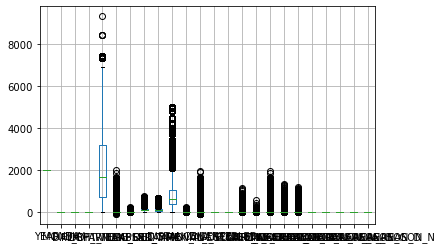

In [19]:
# Check for outliers on continuous variables
# Source: https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas
num_col = df.select_dtypes(include = np.number).columns.tolist() 
df.boxplot(column = num_col)

Note... need to do some more work here, group at different scales or split out individually

#### TO DO (BLAKE)

- Address outliers
- Amber work on airport codes
- We need to finish cleaning up the time conversions (someone)

## Simple Statistics

`Visualize appropriate statistics (e.g., range, mode, mean, median, variance, counts) for a subset of attributes. Describe anything meaningful you found from this or if you found something potentially interesting. Note: You can also use data from other sources for comparison. Explain why the statistics run are meaningful.`

In [4]:
df.describe()

,Unnamed: 0,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,DEPARTED,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,CANCELLATION_REASON_A,CANCELLATION_REASON_B,CANCELLATION_REASON_C,CANCELLATION_REASON_D,CANCELLATION_REASON_N
count,5.789165e+06,5789165.0,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5789165.0,5.789165e+06,5.789165e+06,5789165.0,...,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06
mean,2.912033e+06,2015.0,6.529244e+00,1.570191e+01,3.928717e+00,2.174812e+03,1.0,9.174156e+00,1.585693e+01,1.0,...,2.476309e+00,1.398906e-02,3.484605e+00,4.311822e+00,5.355233e-01,3.496359e-03,7.000491e-03,2.481878e-03,3.800203e-06,9.870175e-01
std,1.679140e+06,0.0,3.403785e+00,8.780918e+00,1.988249e+00,1.758028e+03,0.0,3.666456e+01,9.010045e+00,0.0,...,1.308833e+01,9.191515e-01,2.190996e+01,2.062496e+01,8.830108e+00,5.902656e-02,8.337557e-02,4.975659e-02,1.949407e-03,1.131989e-01
min,0.000000e+00,2015.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,-8.200000e+01,0.000000e+00,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.458804e+06,2015.0,4.000000e+00,8.000000e+00,2.000000e+00,7.310000e+02,1.0,-5.000000e+00,1.100000e+01,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,2.913676e+06,2015.0,7.000000e+00,1.600000e+01,4.000000e+00,1.691000e+03,1.0,-1.000000e+00,1.400000e+01,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,4.366420e+06,2015.0,9.000000e+00,2.300000e+01,6.000000e+00,3.234000e+03,1.0,7.000000e+00,1.900000e+01,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,5.819078e+06,2015.0,1.200000e+01,3.100000e+01,7.000000e+00,9.855000e+03,1.0,1.988000e+03,2.250000e+02,1.0,...,1.134000e+03,5.730000e+02,1.971000e+03,1.331000e+03,1.211000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


As we saw from the outset, the data spans for all months in the year of 2015. Based on the structure of our data, not a lot can be gleaned from the summary statistics and individual variables need additional exploration outside of the overall summary. Let's start by verifying total number of flights within the data set that have been cancelled or diverted.

In [5]:
#check counts of cancels and diversions
df.groupby('CANCELLED')['YEAR'].count()

CANCELLED
0    5714007
1      75158
Name: YEAR, dtype: int64

What does this translate to in terms of percentages?

In [6]:
pct_cancel = round((len(df[df.CANCELLED != 0]))/len(df) * 100,2)

print("The percentage of flights cancelled is ", pct_cancel, "%")

The percentage of flights cancelled is  1.3 %


This is a heavily imbalanced data set! We will need to keep this in mind for our test and train split and over or undersample accordingly. Overall, out of 5 million+ flights, only 1.3% were cancelled in 2015. This equates to 75,158 flights out of 5,714,007.

In [22]:
df.groupby('DIVERTED')['YEAR'].count()

DIVERTED
0    5708334
Name: YEAR, dtype: int64

Our imputation and subsequent removal of missing values has now eliminated all of the diverted flights. This is acceptable as our main interest is in cancellations and arrival delays and not necessarily counts of diversion.

Now let us determine counts of cancels by cancellation reason.

In [ ]:
#make subset of just cancelled flights
cancel = df[df.CANCELLED != 0]

pct_A = round((len(cancel[cancel.CANCELLATION_REASON_A != 0]))/len(cancel) * 100,1)
pct_B = round((len(cancel[cancel.CANCELLATION_REASON_B != 0]))/len(cancel) * 100,1)
pct_C = round((len(cancel[cancel.CANCELLATION_REASON_C != 0]))/len(cancel) * 100,1)
pct_D = round((len(cancel[cancel.CANCELLATION_REASON_D != 0]))/len(cancel) * 100,3)

print("The percentage of flights cancelled due to the airline or carrier is ", pct_A, "%")
print("The percentage of flights cancelled due to weather is ", pct_B, "%")
print("The percentage of flights cancelled due to air traffic control is ", pct_C, "%")
print("The percentage of flights cancelled due to security is ", pct_D, "%")

The majority of flight cancellations from this data set are due to weather. There are very few flights that are cancelled because of security reasons.

Next, let's see if there is any useful insights based on what day of the week that flight is scheduled on.

#### TO DO (MEGAN)


## Visualize Attributes

`Visualize the most interesting attributes (at least 5 attributes, your opinion on what is interesting). Important: Interpret the implications for each visualization. Explain for each attribute why the chosen visualization is appropriate.`

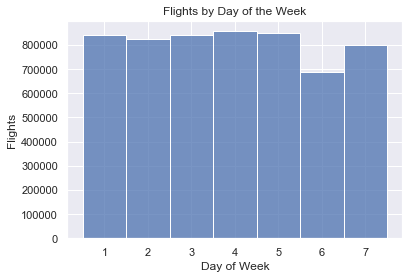

In [44]:
# Flights by day of the week
sns.histplot(df, x = 'DAY_OF_WEEK', discrete=True)

plt.title('Flights by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Flights')

plt.show()

Interestingly, day 6 (Saturday) has more than 100,000 fewer flights than the other days of the week. We would have thought that the counts across days would be more evenly distributed, but upon further reflection that makes sense. Weekday travel for business is fairly consistent. Travelers flying over the weekend would most likely fly out prior to the weekend if possible in order to maximize their weekend time. 

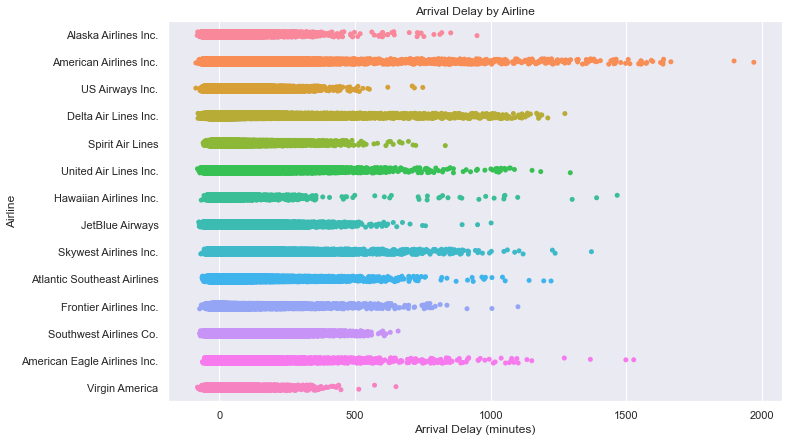

In [38]:
# Set plot size
fig, scatter = plt.subplots(figsize = (11,7))

# Arrival delay by airline
sns.stripplot(x='ARRIVAL_DELAY', y='AIRLINE',
              data=df, dodge=True, jitter=True).set(title='Arrival Delay by Airline')

plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Airline')

plt.show()

Visualizing the arrival delay in minutes by airline, all of the airlines had some amount of flights that departed early (left of the '0' mark on the x-axis). 

In general, Hawaiian Airlines Inc. and Virgin America appear to have the smallest arrival delays of all of the airlines. American Airlines Inc. (AAL) shows the widest range of delays with a strong concentration of delays between 0 and 1,000 minutes (~0-16 hours) that then tapers off around 1,700 minutes (~28 hours) and finally two outliers close to 2,000 minutes (~33 hours).

#### TO DO (EVERYONE)

- Create 2+ visualizations per person plus an explanation for each

## Explore Joint Attributes

`Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.`

In [ ]:
#re-assess numeric/float variables for corr plot
#df.info()

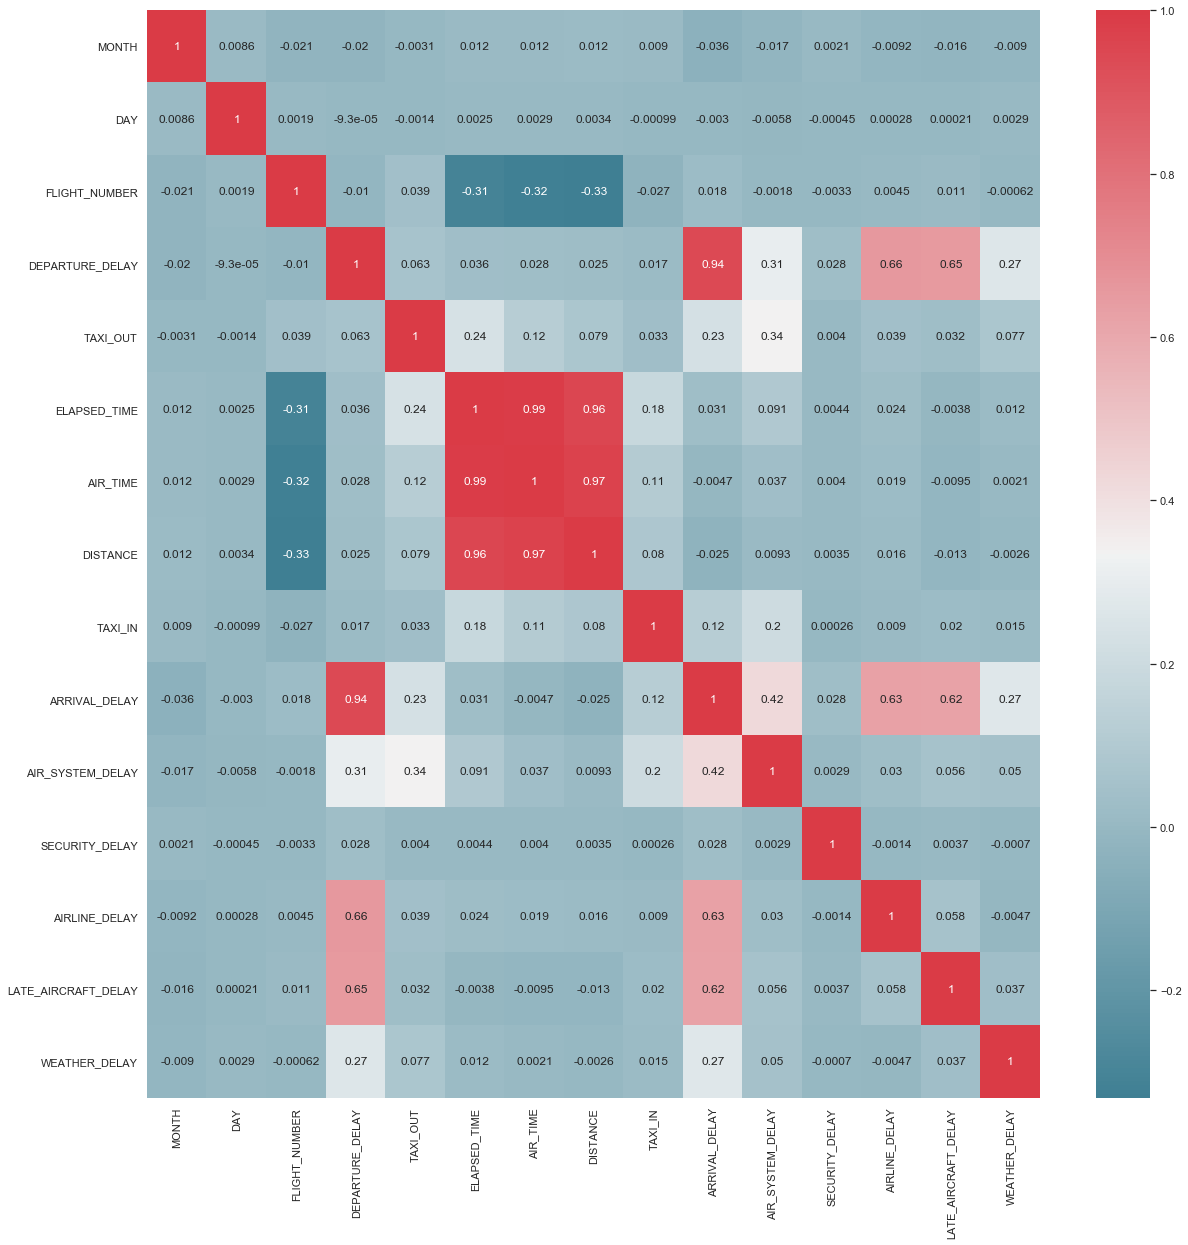

In [7]:
# Examine correlation visually using Seaborn. (Code adapted from 02. Data Visualization.ipynb)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

#subset for continuous variables only
num = df[['MONTH', 'DAY','FLIGHT_NUMBER',
          'DEPARTURE_DELAY','TAXI_OUT',
          'ELAPSED_TIME','AIR_TIME','DISTANCE',
          'TAXI_IN','ARRIVAL_DELAY','AIR_SYSTEM_DELAY',
          'SECURITY_DELAY','AIRLINE_DELAY',
          'LATE_AIRCRAFT_DELAY','WEATHER_DELAY']]

sns.heatmap(num.corr(), cmap=cmap, annot = True)

`ELAPSED_TIME`, `AIR_TIME`, and `DISTANCE` are all highly correlated to each other. This makes sense as these values are all dependent on one another. Additionally, `DEPARTURE_DELAY` and `ARRIVAL_DELAY` are also highly correlated. For the purposes of additional visualizations, we will keep these in for now and review which variables to remove within our training parameters.

#### TO DO (MEGAN)

## Explore Attributes and Class

`Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).`

#### TO DO (AMBER)

## New Features 

`Are there other features that could be added to the data or created from existing features? Which ones?`

#### TO DO (BLAKE)

## Exceptional Work

`You have free reign to provide additional analyses. One idea: implement dimensionality reduction, then visualize and interpret the results. (aka PCA)`

In [26]:
# Look at what continuous variables we have to work with
df.select_dtypes(np.number).head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,DEPARTURE_DELAY,TAXI_OUT,ELAPSED_TIME,AIR_TIME,DISTANCE,...,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,CANCELLATION_REASON_A,CANCELLATION_REASON_B,CANCELLATION_REASON_C,CANCELLATION_REASON_D,CANCELLATION_REASON_N
0,2015,1,1,4,98,-11.0,21.0,194.0,169.0,1448,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
1,2015,1,1,4,2336,-8.0,12.0,279.0,263.0,2330,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
2,2015,1,1,4,840,-2.0,16.0,293.0,266.0,2296,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
3,2015,1,1,4,258,-5.0,15.0,281.0,258.0,2342,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
4,2015,1,1,4,135,-1.0,11.0,215.0,199.0,1448,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1


In [27]:
# Select columns for PCA
df_numeric = df[['DEPARTURE_DELAY', 'TAXI_OUT', 'ELAPSED_TIME', 'AIR_TIME', 
            'DISTANCE', 'TAXI_IN', 'ARRIVAL_DELAY', 'DIVERTED', 
            'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 
            'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'CANCELLATION_REASON_A', 
            'CANCELLATION_REASON_B', 'CANCELLATION_REASON_C', 
            'CANCELLATION_REASON_D', 'CANCELLATION_REASON_N']]

In [28]:
df_numeric.shape

(5708334, 18)

In [29]:
# Source: https://towardsdatascience.com/principal-component-analysis-pca-with-scikit-learn-1e84a0c731b0
# Standardize the features
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create the object
scaler = StandardScaler()
# Calculate the mean and standard deviation
scaler.fit(df_numeric)
df_pca_scaled = scaler.transform(df_numeric)

In [30]:
# Calculate the PCA that explains 95% of the variance
pca_95 = PCA(n_components=0.95, random_state=2015)
pca_95.fit(df_pca_scaled)
df_pca_95 = pca_95.transform(df_pca_scaled)

# Display the PCA values
np.cumsum(pca_95.explained_variance_ratio_*100)

array([26.05949726, 50.60752447, 61.51241579, 69.96793895, 78.30235344,
       86.47607986, 94.17304731, 99.32984484])

Text(0, 0.5, 'Explained Variance')

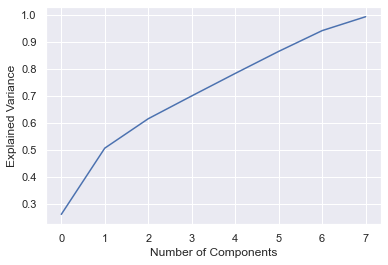

In [31]:
# Plot PCA results
plt.plot(np.cumsum(pca_95.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

The above skree plot shows a sharp uptick in explained variance between PC1 and PC2, then a steady rise until PC7 which brings the total explained variance to 94.173%. 

In [32]:
df_post_pca = pd.DataFrame(df_pca_95, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])
df_post_pca['Cancelled'] = df.CANCELLED
df_post_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Cancelled
0,0.187460,-1.693160,-0.039036,0.668661,-0.032798,-0.492053,-0.218497,-0.142132,0.0
1,1.504133,-3.346636,-0.939539,0.403371,-0.029140,-0.090204,-0.121051,0.611123,0.0
2,2.000487,-3.297390,-0.290363,-0.298375,-0.010068,0.323304,0.117204,-0.090308,0.0
3,1.662409,-3.337228,-0.518949,0.030071,-0.019084,0.116694,0.003855,0.160460,0.0
4,0.384728,-1.915335,-0.712382,0.188741,-0.018902,0.019781,-0.025231,0.508354,0.0
